<a href="https://colab.research.google.com/github/Mahmoudi1993/People_Counting_Real_Time_with_Detectron2/blob/main/Project_Real_Time_People_Counting_Using_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install supervision==0.2.0

In [ ]:
# Install Detectron2
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install file:////content/detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Processing //content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6147334 sha256=8349b7c9f872ac122637a8d2c3a4f1cefee2ae77e23955302866365ad3a3772d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lt4_gkim/wheels/8b/ec/a5/3b10bdf8959eef9543ab09f7d1430331dea05939309991ca77
Successfully built detectron2
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.6
    Uninstalling fvcore-0.1.6:
      Successfully uninstalled fvcore-0.1.6
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
  Attempting uninstall: detectr

# Clone the file from Gihub

In [ ]:
!git clone https://github.com/Mahmoudi1993/People_Counting_Real_Time_with_Detectron2.git

Cloning into 'Detectron2_Watcher'...
remote: Enumerating objects: 1455, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 1455 (delta 101), reused 318 (delta 80), pack-reused 1081
Receiving objects: 100% (1455/1455), 27.28 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (436/436), done.


# Start Detectron

In [ ]:
%cd People_Counting_Real_Time_with_Detectron2/

/content/Detectron2_Watcher


loader the video

Setting the Detectron2.

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import torch, torchvision
from IPython import display
import supervision as sv
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Inference with a pretrained model
In this first "coding" part are two important utils from Detector2. On the one hand we are using cfg or better configs which represents the complete configuration of a object detection model. These configurations are stored within a YAML-file and can be easily received from the modelzoo.

After the configuration is complete we'll use the DefaultPredictor class to make predictions.

In [ ]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can either use the https://dl.fbaipublicfiles.... url, or use the following shorthand
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
predictor = DefaultPredictor(cfg)

[02/02 19:51:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 271MB/s]                           


**what number stands for which class?**

Every dataset is associated with metadata. It is a key-value mapping that contains information about
the dataset.( mapping: MetadataCatalog.get(cfg.DATASETS.TRAIN[0]) )
It can be used to further interpret the dataset. This information can later be used for data augmentation, evaluation, visualization, logging, ...

In [ ]:
# which objects it can recognize:
# classes_id
import pandas as pd
modelclasses = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
df = pd.DataFrame(modelclasses,columns=['Model classes'])
df

Model classes
0         person
1        bicycle
2            car
3     motorcycle
4       airplane
..           ...
75          vase
76      scissors
77    teddy bear
78    hair drier
79    toothbrush

[80 rows x 1 columns]

In [ ]:
INPUT_VIDEO_PATH = "/content/People_Counting_Real_Time_with_Detectron2/example/People_test_0.mp4"

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


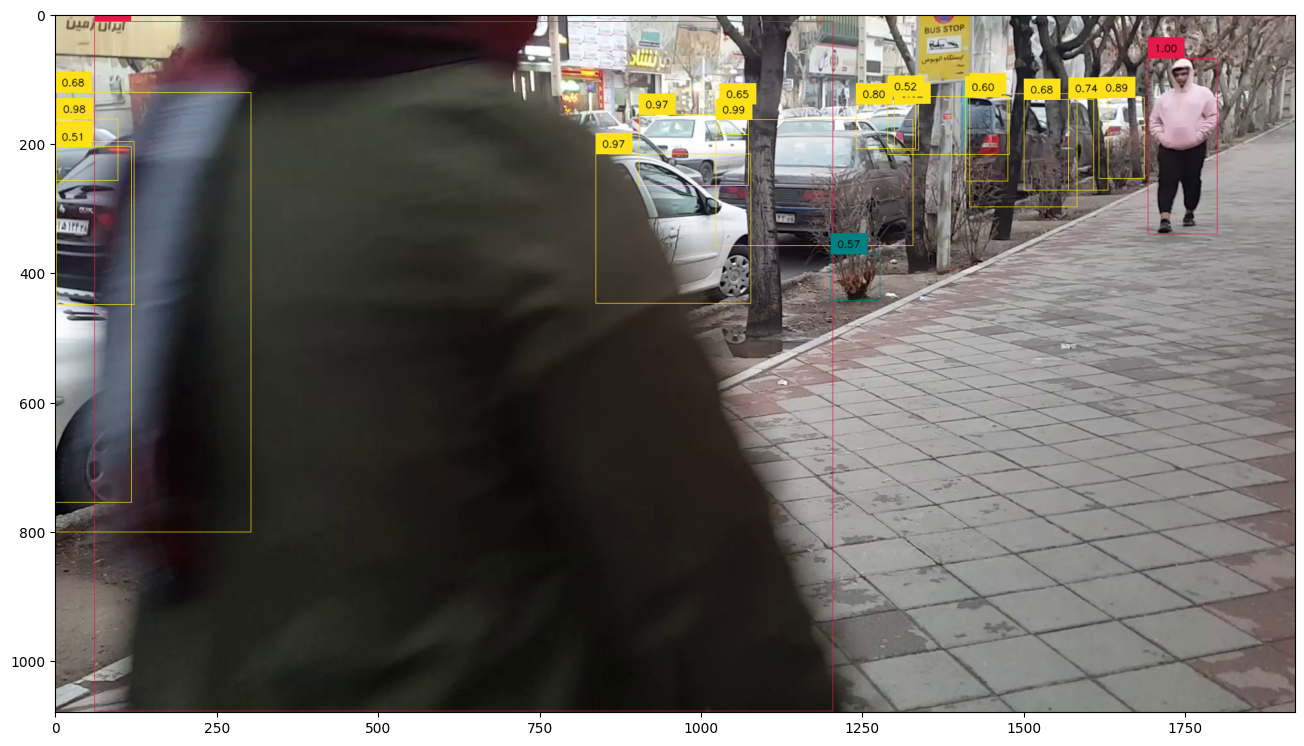

In [ ]:
# Without_classes_id_person

# extract video frame
generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)


# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

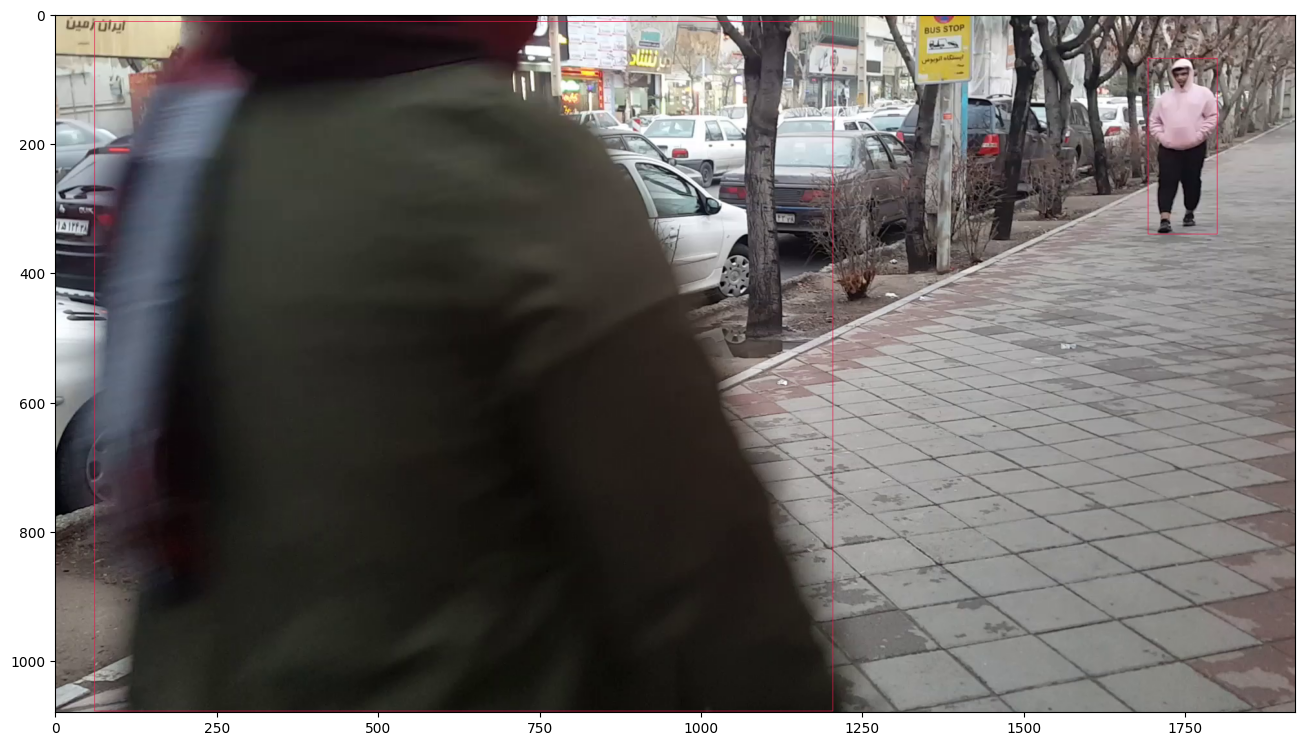

In [ ]:
# With_classes_id_person

# extract video frame
generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
# information input_video
sv.VideoInfo.from_video_path(INPUT_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=632)

**Calculate Coordinates for a Polygon Zone**

we’re going to show how to count objects in a zone using supervision and PolygonZone, an accompanying tool for calculating the coordinates for zones in an image or video.

Before we can start counting objects in a zone, we need to first define the zone in which we want to count objects.

To calculate coordinates inside a zone, we can use PolygonZone, an interactive web application that lets you draw polygons on an image and export their coordinates for use with supervision.

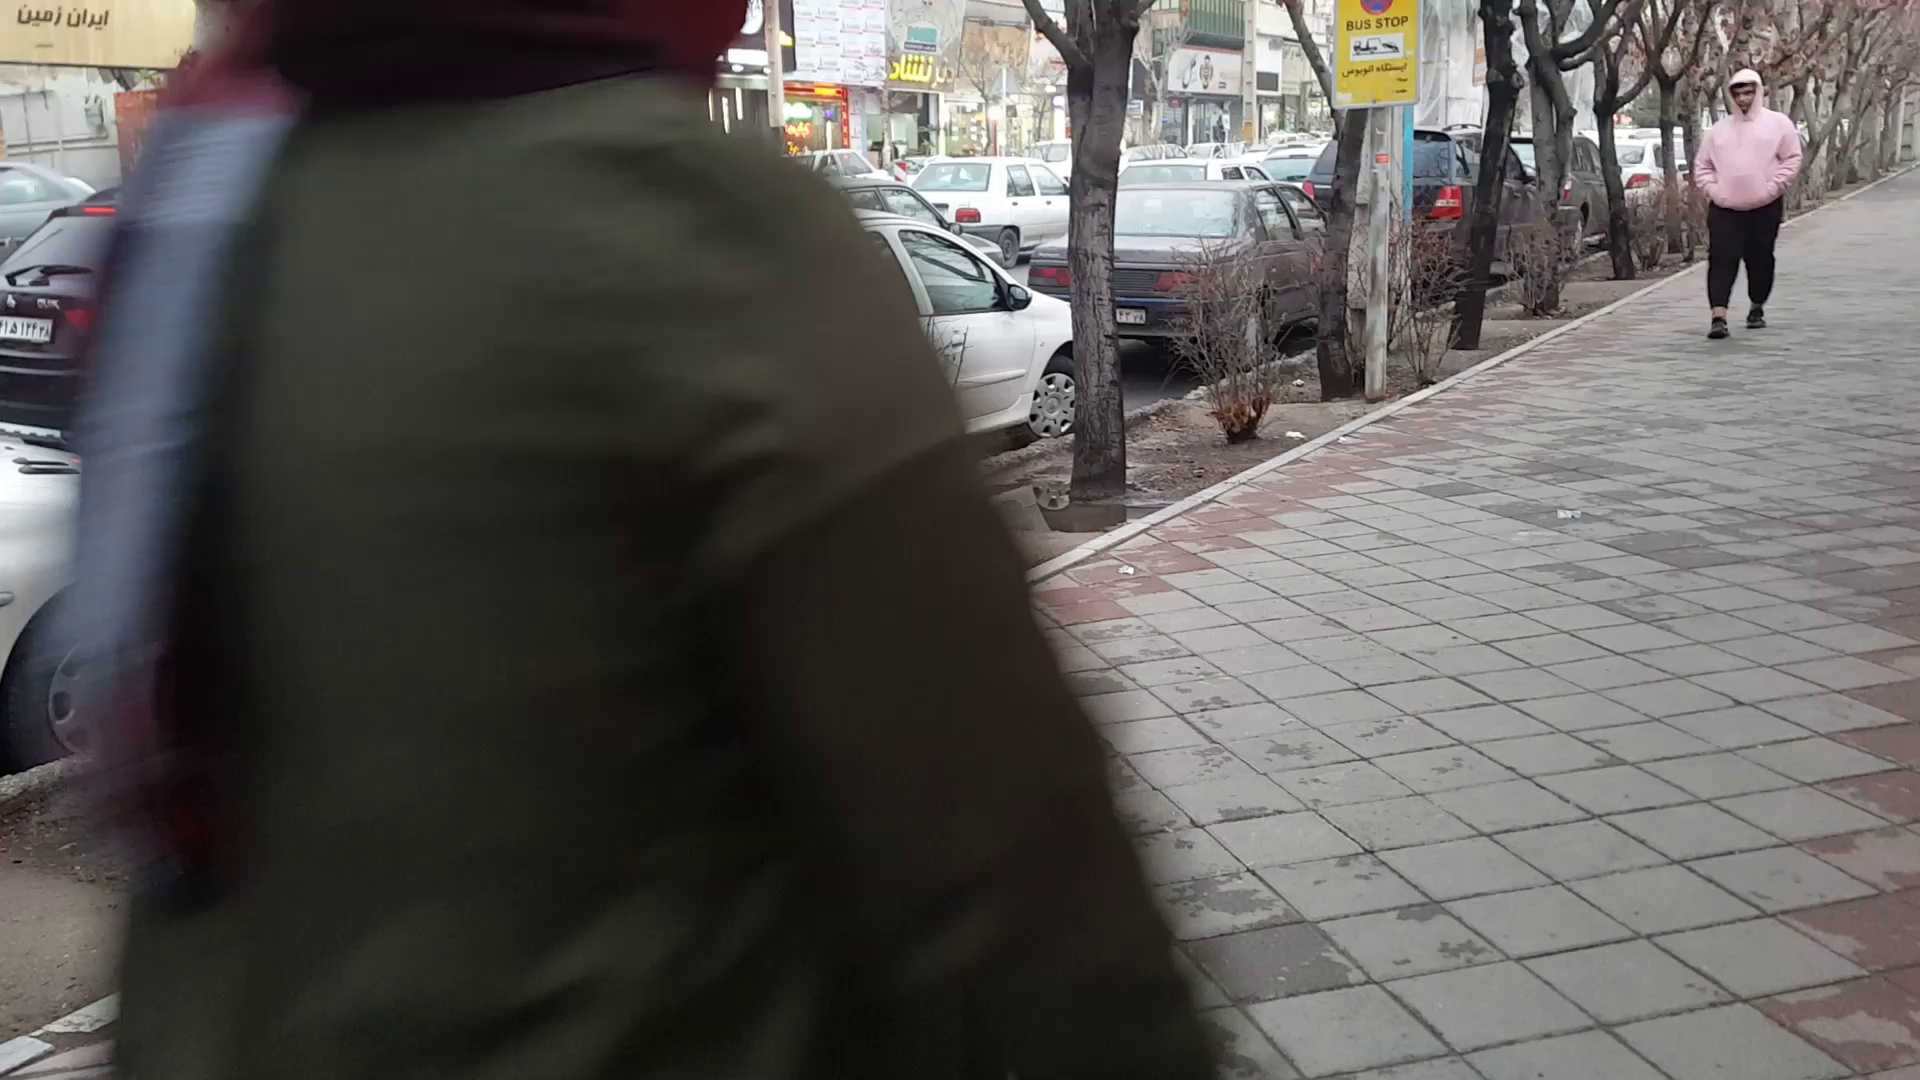

In [ ]:
# PolgyonZone needs a frame from the video with which you will be working.
# We can extract a frame from our video using the following code:

import supervision as sv
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

generator = sv.get_video_frames_generator("/content/People_Counting_Real_Time_with_Detectron2/example/People_test_0.mp4")
iterator = iter(generator)
frame = next(iterator)

OUTPUT_VIDEO_PATH = r'/content/People_Counting_Real_Time_with_Detectron2/Results'
os.chdir(OUTPUT_VIDEO_PATH)

cv2.imwrite("People_test_0.jpg", frame)



img = cv2.imread('/content/Detectron2_Watcher/Results/People_test_0.jpg')
cv2_imshow(img)

We can now use this image to calculate the coordinates of the zone we want to draw on our image. First, open up PolygonZone (
https://roboflow.github.io/polygonzone/ )
and upload the frame.

Then, click on points in the image where you want to draw lines. When you have drawn the full zone, click “enter” to connect the dots between the start and finish point.

Once you have added your points, a NumPy array will be available on the page. This array contains the coordinates for the points in our zone.

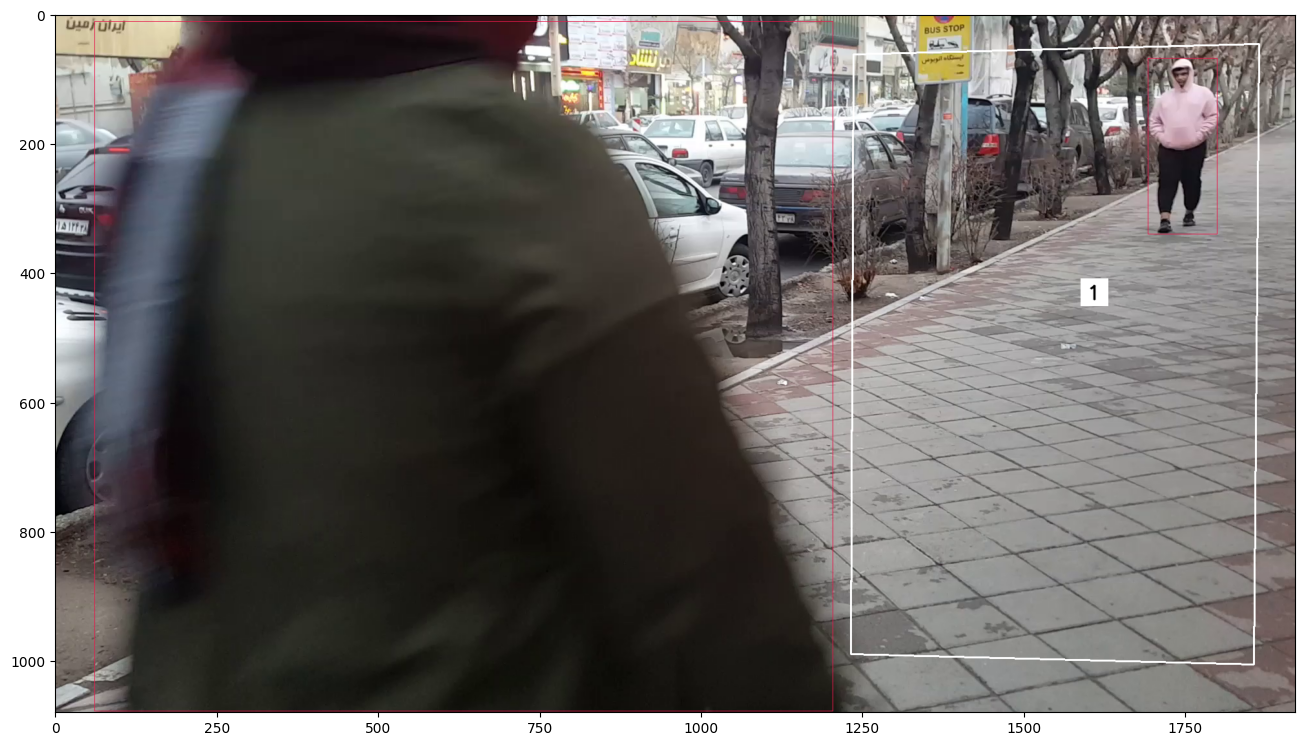

In [ ]:
# With the zone coordinates ready, we can now start counting objects in the zone.
import numpy as np
import supervision as sv

# initiate polygon zone Car_test_0
# polygon_Car_test_0 = np.array([
#                   [420, 190],[428, 366],
#                   [88, 354],[344, 190],
#                   [420, 190]
#          ])


# initiate polygon zone People_test_0

polygon = np.array([
                   [1864, 46],[1856, 1006],
                   [1232, 990],[1236, 62],
                   [1860, 46]
        ])


video_info = sv.VideoInfo.from_video_path(INPUT_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=2, text_thickness=2, text_scale=1)

# extract video frame
generator = sv.get_video_frames_generator(INPUT_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
outputs = predictor(frame)
detections = sv.Detections(
    xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
    confidence=outputs["instances"].scores.cpu().numpy(),
    class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [ ]:
# People Counting on vidoe
# Inference time will depend on how long your video is and the hardware on which you are running.

import numpy as np
import supervision as sv

# initiate polygon zone Car_test_0
# polygon = np.array([
#                   [420, 190],[428, 366],
#                   [88, 354],[344, 190],
#                   [420, 190]
#          ])


# initiate polygon zone People_test_0

polygon = np.array([
                   [1864, 46],[1856, 1006],
                   [1232, 990],[1236, 62],
                   [1860, 46]
        ])

video_info = sv.VideoInfo.from_video_path(INPUT_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=2, text_thickness=2, text_scale=1)

def process_frame(frame: np.ndarray, i: int) -> np.ndarray:
    print('frame', i)
    # detect
    outputs = predictor(frame)
    detections = sv.Detections(
        xyxy=outputs["instances"].pred_boxes.tensor.cpu().numpy(),
        confidence=outputs["instances"].scores.cpu().numpy(),
        class_id=outputs["instances"].pred_classes.cpu().numpy().astype(int)
    )
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)
    frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=INPUT_VIDEO_PATH, target_path="/content/People_Counting_Real_Time_with_Detectron2/Results/People_test_0_result.mp4", callback=process_frame)

from IPython import display
display.clear_output()